### <center> Sentiment Analysis on Movie Review

In [20]:
#Import packages
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import re

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Bidirectional, LSTM, GlobalMaxPool1D

In [2]:
#Read dataset
df_train = pd.read_csv('data/labeledTrainData.tsv', delimiter='\t')
df_train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [9]:
#Read test dataset
df_test  = pd.read_csv('data/testData.tsv', delimiter='\t')
df_test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [5]:
#Function to clean dataset
#Function to clean text
def clean_text(input_text):
    """
    Processes the give text and removes all non words, digits, single letters and extra spaces.

    Parameters
    -----------
    1. input_text = Text to clean.
    2. token = 'word' or 'sentence'

    Returns: Text.

    """

    text = re.sub(r'\W',' ', input_text) #Remove all non words
    text = re.sub(r'\d+',' ', text) #Remove all digits
    text = text.lower() #Converting text into lowercase
    text = re.sub(r'\s+[a-z]\s+',' ', text) #Remove all single letters
    text = re.sub(r'^\s+','', text) #Remove space from start of text
    text = re.sub(r'\s+$','', text) #Remove space from end of text
    text = re.sub(r'\s+',' ', text) #Remove all multi space    
    text = text.split(' ') #Split the words into tokens
    text = [word for word in text if word not in stop_words] #Remove stopwords
    text = [WordNetLemmatizer().lemmatize(word) for word in text] #Lemmatize the words(get root form)
    text = ' '.join(text)

    return text

In [8]:
#Clean the train review data
df_train['cleaned_review'] = df_train['review'].apply(lambda x: clean_text(x))
df_train['cleaned_review'].head(3)

0    stuff going moment mj started listening music ...
1    classic war world timothy hines entertaining f...
2    film start manager nicholas bell giving welcom...
Name: cleaned_review, dtype: object

In [10]:
#Clearn test review data
df_test['cleaned_review'] = df_test['review'].apply(lambda x: clean_text(x))
df_test['cleaned_review'].head(3)

0    naturally film main theme mortality nostalgia ...
1    movie disaster within disaster film full great...
2    movie kid saw tonight child loved one point ki...
Name: cleaned_review, dtype: object

In [14]:
#Average length of review
AvgLength  = df_train['cleaned_review'].apply(lambda x: len(x.split(' '))).mean()
print('Average length of Review: ', AvgLength)

Average length of Review:  123.35284


In [12]:
#Preprocess cleaned review for modelling
tokenizer = Tokenizer(num_words = 6000)
tokenizer.fit_on_texts(df_train['cleaned_review'])

In [15]:
#Sequence Train and Test review
train_sequence = tokenizer.texts_to_sequences(df_train['cleaned_review'])
test_sequence = tokenizer.texts_to_sequences(df_test['cleaned_review'])

In [16]:
#Pad Sequence for equal length of review
X_train = pad_sequences(train_sequence, maxlen=130)
X_test = pad_sequences(test_sequence, maxlen=130)

In [17]:
#Set up target value
y_train = df_train['sentiment']

In [18]:
#Review shape of training set
X_train.shape, y_train.shape

((25000, 130), (25000,))

In [19]:
#Review test set
X_test.shape

(25000, 130)

## Building the NN Model

In [22]:
model = Sequential()

#Add embedding layer
model.add(Embedding(6000, 128))

#Add Bidrectional RNN Layer
model.add(Bidirectional(LSTM(64, return_sequences=True)))

#Add Dense Layer
model.add(Dense(128, activation='relu'))

#Add MaxPooling Layer
model.add(GlobalMaxPool1D())

#Add Output Layer
model.add(Dense(1, activation='sigmoid'))

#Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         768000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dense_3 (Dense)              (None, None, 128)         16512     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 883,457
Trainable params: 883,457
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Fit the model
model.fit(X_train, y_train, batch_size=100, epochs=3, validation_split=0.2)

C:\Users\rajas\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 212s 11ms/step - loss: 0.4032 - accuracy: 0.8098 - val_loss: 0.2997 - val_accuracy: 0.8702
Epoch 2/3
20000/20000 [==============================] - 197s 10ms/step - loss: 0.2276 - accuracy: 0.9115 - val_loss: 0.3107 - val_accuracy: 0.8708
Epoch 3/3
20000/20000 [==============================] - 197s 10ms/step - loss: 0.1811 - accuracy: 0.9317 - val_loss: 0.3598 - val_accuracy: 0.8620


In [26]:
sentiment_prediction = model.predict(X_train)

In [32]:
#Evaluating model prediction
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [28]:
prediction = (sentiment_prediction)>0.5
prediction[:5]

array([[False],
       [ True],
       [False],
       [False],
       [ True]])

In [29]:
#F1 Score
f1_score(y_train, prediction)

0.9429608186896075

In [30]:
#Model Accuracy
accuracy_score(y_train, prediction)

0.94404

In [31]:
#Plotting Confusion Matrix
confusion_matrix(y_train, prediction)

array([[12037,   463],
       [  936, 11564]], dtype=int64)

In [33]:
#Plot roc curve
roc_auc_score(y_train, prediction)

0.9440400000000001

In [34]:
roc_curve(y_train, prediction)

(array([0.     , 0.03704, 1.     ]),
 array([0.     , 0.92512, 1.     ]),
 array([2, 1, 0]))

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

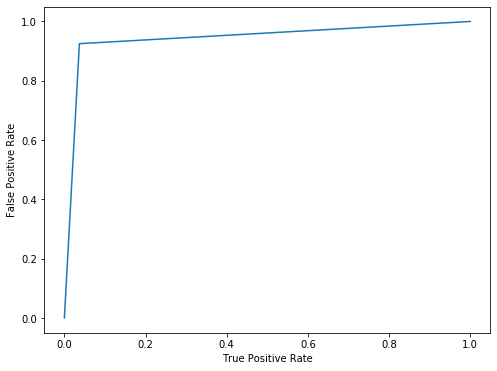

In [46]:
plt.figure(figsize=(8,6))
tpr, fpr, _ = roc_curve(y_train, prediction)
plt.plot(tpr, fpr)
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.show();